# Setup

In [1]:
import stan
import pandas as pd
import numpy as np
import scipy.stats as stats 
import matplotlib
import arviz as az
import matplotlib.pyplot as plt
#matplotlib.rcParams['figure.figsize']=5,5
matplotlib.rcParams['figure.dpi']=100
#plt.style.use('ggplot')
from IPython.display import Image

In [2]:
# this is a work around found at 
# https://stackoverflow.com/questions/56154176/runtimeerror-asyncio-run-cannot-be-called-from-a-running-event-loop-in-spyd
import nest_asyncio
nest_asyncio.apply()

In [82]:
import os
import sys
os.environ['STAN_NUM_THREADS'] = "16"
os.environ['STAN_THREADS'] = "True"

## Import and prepare data

In [3]:
# Import data: practices performed in each clinic during 40 days
data0 = pd.read_csv('Medical-practices.csv', index_col=0)
# Prepare a slice of data that conserves last day, but deletes previous 10 days.  
# In this way we are more sensitive to a change that started within the last 10 days
# since we'll not use that block to learn the pattern
start_not_learning_block=-11
end_not_learning_block=-1
data = data0.iloc[np.r_[-len(data0):start_not_learning_block,end_not_learning_block:end_not_learning_block+1],:]
# Let's see first and last 2 rows
data.iloc[[-len(data),-len(data)+1,-2,-1],:]

Date  Clinic #0  Clinic #1  Clinic #2  Clinic #3  Clinic #4  \
0   2024-08-05       38.0       52.0       81.0       40.0       54.0   
1   2024-08-06       36.0       41.0      101.0       63.0       43.0   
28  2024-09-02       42.0       64.0       99.0       36.0       44.0   
39  2024-09-13       25.0       37.0       59.0       15.0       39.0   

    Clinic #5  Clinic #6  Clinic #7  Clinic #8  ...  Clinic #48  Clinic #49  \
0        26.0       22.0       14.0       30.0  ...        42.0       260.0   
1        29.0       32.0       14.0       39.0  ...        41.0       222.0   
28       18.0       32.0       35.0       43.0  ...        38.0       249.0   
39       20.0       17.0        8.0       31.0  ...        27.0       161.0   

    Clinic #50  Clinic #51  Clinic #52  Clinic #53  Clinic #54  Clinic #55  \
0         47.0        15.0        16.0        19.0       298.0       412.0   
1         46.0        13.0        22.0        21.0       265.0       461.0   
28        51.0         7.0        15.0        38.0       244.0       462.0   
39        35.0        16.0        18.0        12.0       246.0       293.0   

    Clinic #56  Clinic #57  
0         18.0      1139.0  
1         15.0      1426.0  
28        11.0      1347.0  
39         8.0       866.0  

[4 rows x 59 columns]

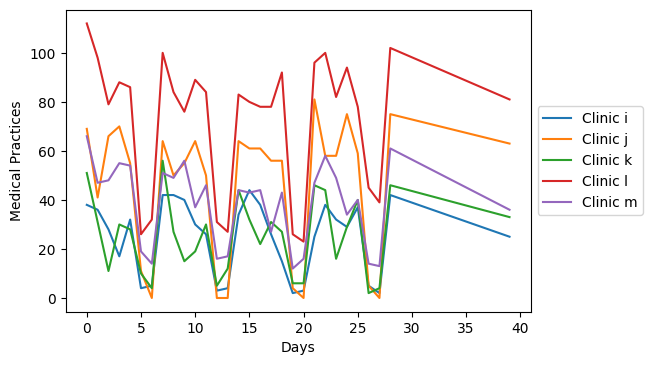

In [4]:
# We verify the hypothesis: there is an approximate ratio in practices for all clinics
# And fluctuations we assume that come from the draw of a Poisson with a given rate
plt.plot(data[list(data)[1]], label='Clinic i')
plt.plot(data[list(data)[12]], label='Clinic j')
plt.plot(data[list(data)[17]], label='Clinic k')
plt.plot(data[list(data)[19]], label='Clinic l')
plt.plot(data[list(data)[15]], label='Clinic m')
plt.xlabel('Days')
plt.ylabel('Medical Practices')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Bayesian modeling with STAN

We model the number o medical practices performed by clinic $n$ on day $t$ as being drawn from a Poisson distribution whose rate is the product of clinic $n$ size time the given day $t$ <i>magnitude</i>:
$$ practices \sim Poisson (s_n\, d_t)$$


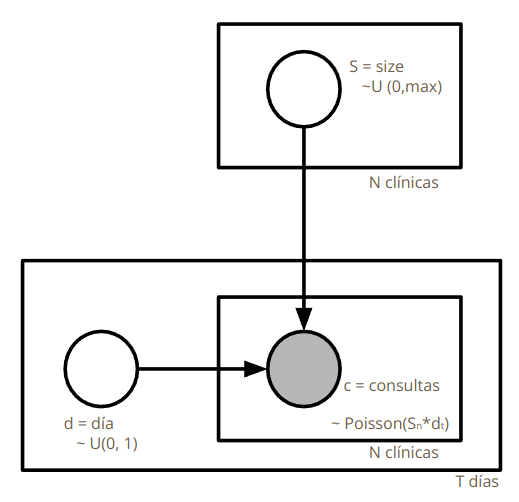

In [5]:
Image("graphical_model.png")

In [24]:
my_basic_model="""
data {
 int <lower=0> N; // number of clinics
 int <lower=0> T; // number of days in the dataset
 int <lower=0> my_max; // maximum number of practices in the dataset (used to break degeneracy)
 array[T,N] int<lower=0> practices;  // practices on day t in clinic n: practices[t,n] 
}

parameters {
  vector<lower=0, upper=1>[T] d; // parameter that measures how 'hot' is each day
  vector<lower=0, upper=my_max>[N] s; // parameter that estimates the size of each clinic
  // Challenge: include in the model 
  // 1- Some days a doctor may not come and the clinic is smaller for that day
  // 2- People leaves a clinic if there is a long wait... can you do it?
  
}

model {
   for (n in 1:N) {
       for (t in 1:T) {           
           practices[t,n] ~ poisson( d[t]*s[n] );
     }; 
     };
}
"""

In [13]:
# Let's define the aforementioned model to be executed with Stan
my_model_with_parallel_sampling="""
functions{
real partial_sum(array[,] int practices, int N,
                   int start, int end,
                   vector d,
                   vector s)
                   {

    real partial_target = 0;
    int slice_length = end-start+1;

    for (k in 1:slice_length)
        {       
        for (n in 1:N) {
             partial_target += poisson_lpmf(practices[k,n] |  d[start-1+k]*s[n] );
             }
        }

    return partial_target;
    }
}


data {
 int <lower=0> N; // number of clinics
 int <lower=0> T; // number of days in the dataset
 int <lower=0> my_max; // maximum number of practices in the dataset (used to break degeneracy)
 array[T,N] int<lower=0> practices;  // practices on day t in clinic n: practices[t,n] 
}

parameters {
  vector<lower=0, upper=1>[T] d; // parameter that measures how 'hot' is each day
  vector<lower=0, upper=my_max>[N] s; // parameter that estimates the size of each clinic
  // real<lower=0> eps;
  // Challenge: include in the model 
  // 1- Some days a doctor may not come and the clinic is smaller for that day
  // 2- People leaves a clinic if there is a long wait... can you do it?  
}

model {
  int grainsize = 1;  
  target += reduce_sum(partial_sum, practices, N, grainsize, d, s);
}

"""

In [17]:
# Let's define the aforementioned model to be executed with Stan
my_model_with_parallel_sampling="""
functions{
real partial_sum(array[,] int practices,
                   int start, int end,
                   vector d,
                   vector s,
                   int N)
                   {

    real partial_target = 0;
    int slice_length = end-start+1;

    for (k in 1:slice_length)
        {       
        for (n in 1:N) {
             partial_target += poisson_lpmf(practices[k,n] |  d[start-1+k]*s[n] );
             }
        }

    return partial_target;
    }
}


data {
 int <lower=0> N; // number of clinics
 int <lower=0> T; // number of days in the dataset
 int <lower=0> my_max; // maximum number of practices in the dataset (used to break degeneracy)
 array[T,N] int<lower=0> practices;  // practices on day t in clinic n: practices[t,n] 
}

parameters {
  vector<lower=0, upper=1>[T] d; // parameter that measures how 'hot' is each day
  vector<lower=0, upper=my_max>[N] s; // parameter that estimates the size of each clinic
  // real<lower=0> eps;
  // Challenge: include in the model 
  // 1- Some days a doctor may not come and the clinic is smaller for that day
  // 2- People leaves a clinic if there is a long wait... can you do it?  
}

model {
  int grainsize = 1;  
  target += reduce_sum(partial_sum, practices, grainsize, d, s, N);
}

"""

In [76]:
# We define the dictionary that contains the data the model needs
# Do you understand why the my_max variable is used to break a degeneracy ?
practices = np.array(data[list(data)[1:]]).astype(int)
my_data = {'N':practices.shape[1], 'T':practices.shape[0], 'my_max': int(data[list(data)[1:]].max().max()), 'practices': practices }

In [73]:
extra_compile_args = ['-pthread', '-DSTAN_THREADS']

In [75]:
stan_model = stan.model(
    model_code=my_model_with_parallel_sampling,
    extra_compile_args=extra_compile_args
)

TypeError: 'module' object is not callable

In [ ]:
stan.model

In [83]:
# Plug the data in the model and build it
# One of the models has less parameters, but it will be shown to be too restricted (not good convergence)
model = stan.build(my_model_with_parallel_sampling, data=my_data, random_seed=1);
#model = stan.build(my_basic_model, data=my_data, random_seed=3);

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_ywhf__gf/model_bu35q3c5.stan', line 43, column 12: The
    variable partial_sum may not have been assigned a value before its use.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [85]:
%%time
# We fit the model: we cample from the posterior
fit = model.sample(num_chains=4, num_samples=1000)#, num_warmup=1000, delta=0.9)

Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000732 seconds
  1000 transitions using 10 leapfrog steps per transition would take 7.32 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.011677 seconds
  1000 transitions using 10 leapfrog steps per transition would take 116.77 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00018 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.8 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000231 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.31 seconds.
  Adjust your expectations accordingly!


CPU times: user 293 ms, sys: 24 ms, total: 317 ms
Wall time: 315 ms


In [59]:
# We display the info in a dataframe to work it out more easily
df = fit.to_frame() 
df

parameters         lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
draws                                                                           
0          -7575.377923       0.939352    0.224025          4.0          15.0   
1          -7588.831678       0.991180    0.160252          4.0          31.0   
2          -7593.746515       0.972734    0.099908          5.0          31.0   
3          -7576.977535       0.937362    0.220602          4.0          15.0   
4          -7581.962414       0.899517    0.224025          4.0          15.0   
...                 ...            ...         ...          ...           ...   
3995       -7601.914115       0.245270    0.220602          4.0          15.0   
3996       -7580.199457       0.797322    0.224025          4.0          15.0   
3997       -7575.161815       0.226023    0.160252          4.0          15.0   
3998       -7582.460887       0.998540    0.099908          5.0          31.0   
3999       -7594.144521       0.274683    0.220602          3.0          15.0   

parameters  divergent__     energy__       d.1       d.2       d.3  ...  \
draws                                                               ...   
0                   0.0  7628.784193  0.885629  0.938324  0.795932  ...   
1                   0.0  7634.198015  0.843807  0.898181  0.799170  ...   
2                   0.0  7630.114396  0.898425  0.950766  0.839168  ...   
3                   0.0  7617.919283  0.854683  0.905318  0.783590  ...   
4                   0.0  7619.097256  0.890158  0.924966  0.808828  ...   
...                 ...          ...       ...       ...       ...  ...   
3995                0.0  7639.034901  0.895500  0.929429  0.833975  ...   
3996                0.0  7622.528269  0.862230  0.892291  0.799721  ...   
3997                0.0  7617.718017  0.881205  0.944237  0.825576  ...   
3998                0.0  7627.520032  0.859561  0.886558  0.813312  ...   
3999                1.0  7638.412316  0.896586  0.934451  0.833667  ...   

parameters       s.49        s.50       s.51       s.52       s.53       s.54  \
draws                                                                           
0           49.920665  263.488231  57.465685  15.318795  20.444771  31.915717   
1           50.221397  265.163520  54.444013  15.852474  20.499475  32.550655   
2           48.270315  256.157398  52.084017  14.693530  18.444572  31.104625   
3           52.349469  274.048977  60.607637  16.890611  20.139926  30.836441   
4           49.416950  261.679698  55.248329  15.885125  18.599770  30.457328   
...               ...         ...        ...        ...        ...        ...   
3995        46.328365  261.463320  54.718115  17.230055  21.591035  32.237547   
3996        51.306243  264.401658  57.027781  16.386001  21.436875  30.462530   
3997        47.462388  252.750462  53.584873  15.967038  19.857743  32.462442   
3998        49.434509  259.413608  54.659597  17.947628  21.716474  31.464969   
3999        46.018601  258.823216  55.745171  16.579483  22.026264  31.725520   

parameters        s.55        s.56       s.57         s.58  
draws                                                       
0           298.037489  497.281919  16.056654  1407.109505  
1           298.377014  491.355983  18.184194  1431.260085  
2           284.808466  479.666400  16.366703  1359.309044  
3           301.260734  487.470077  16.341826  1424.156995  
4           294.807440  479.479059  17.241968  1405.766322  
...                ...         ...        ...          ...  
3995        290.659231  471.844429  16.313893  1385.104321  
3996        298.967360  494.348444  18.042946  1437.318158  
3997        289.535408  471.819763  15.877193  1390.935538  
3998        299.244486  497.373384  17.834673  1428.028420  
3999        289.559033  476.426213  16.189488  1368.390096  

[4000 rows x 95 columns]

In [60]:
# Let's diagnose the sampling.  rhat is a variable that measures how good the chains have reached a stationary state
# rhat < 1.05 is good enough
azdata = az.from_pystan(fit)
summary = az.summary(azdata)
summary

mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
d[0]      0.887   0.023     0.845     0.927      0.004    0.003      34.0   
d[1]      0.927   0.024     0.883     0.972      0.004    0.003      34.0   
d[2]      0.814   0.021     0.776     0.854      0.004    0.003      37.0   
d[3]      0.832   0.022     0.795     0.872      0.004    0.003      37.0   
d[4]      0.679   0.018     0.646     0.711      0.003    0.002      41.0   
...         ...     ...       ...       ...        ...      ...       ...   
s[53]    31.506   1.459    28.779    34.199      0.097    0.069     220.0   
s[54]   290.558   7.398   277.663   304.438      1.251    0.892      37.0   
s[55]   485.179  11.488   465.292   506.192      2.220    1.588      28.0   
s[56]    16.926   1.042    14.892    18.787      0.062    0.044     279.0   
s[57]  1397.700  29.463  1348.359  1438.945      6.074    4.349      28.0   

       ess_tail  r_hat  
d[0]       63.0   1.09  
d[1]       38.0   1.09  
d[2]       51.0   1.08  
d[3]       69.0   1.09  
d[4]       56.0   1.08  
...         ...    ...  
s[53]     416.0   1.02  
s[54]      53.0   1.09  
s[55]      33.0   1.11  
s[56]     787.0   1.01  
s[57]      34.0   1.11  

[88 rows x 9 columns]

The rhat should be below 1.01 (1.05 acceptable) to have a fully confident sampling.  It is "ok"

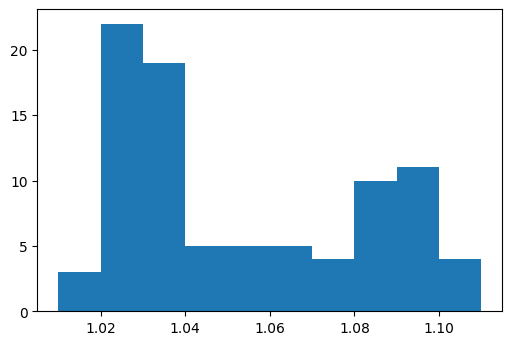

In [61]:
plt.hist(summary['r_hat'])
plt.show()

### Let's sort the clinics

We sort them from most unlikely because of being above the expectation, to the most unlikey of being below the expectation.  All this corresponds to the given day of study "$d_0$" in which we are testing the anomaly.

We can compute the average p-value 
$$\langle p_n \rangle = \langle \sum_{x=practices[n]@d_0}^\infty Poisson(x; d_0 \cdot s[n]) \rangle $$
for every clinic $n$, where $d_0$  is the day of study.  The clinic that has the minimum $\langle p_n \rangle$ is the most unlikely from above, that we're looking for.

In [62]:
# Dataframe with all the required info to compute <p_n>
my_day = df[['d.'+str(len(data))]+['s.'+str(i+1) for i in range(len(list(data))-1)]]
my_day[:4]

parameters      d.30        s.1        s.2         s.3        s.4        s.5  \
draws                                                                          
0           0.624694  39.973750  55.496243  101.056123  45.796645  43.500063   
1           0.616282  39.828559  55.460794  102.000415  43.308315  45.141638   
2           0.648359  38.511094  52.804559   95.752043  42.807711  40.103400   
3           0.610460  41.440305  55.759430   99.931612  46.913379  44.751023   

parameters        s.6        s.7        s.8        s.9  ...       s.49  \
draws                                                   ...              
0           43.055003  26.567763  29.713395  41.193501  ...  49.920665   
1           44.733542  28.467476  32.003493  44.131890  ...  50.221397   
2           41.031296  27.518170  32.906565  39.386910  ...  48.270315   
3           41.978104  29.175685  29.694522  41.776069  ...  52.349469   

parameters        s.50       s.51       s.52       s.53       s.54  \
draws                                                                
0           263.488231  57.465685  15.318795  20.444771  31.915717   
1           265.163520  54.444013  15.852474  20.499475  32.550655   
2           256.157398  52.084017  14.693530  18.444572  31.104625   
3           274.048977  60.607637  16.890611  20.139926  30.836441   

parameters        s.55        s.56       s.57         s.58  
draws                                                       
0           298.037489  497.281919  16.056654  1407.109505  
1           298.377014  491.355983  18.184194  1431.260085  
2           284.808466  479.666400  16.366703  1359.309044  
3           301.260734  487.470077  16.341826  1424.156995  

[4 rows x 59 columns]

In [63]:
clinics = list(data)[1:] # starts at 1 because column 0 is the date
probabilities = pd.DataFrame()
for i in range(len(clinics)):
    if i % 10 ==0: print(i,'/',len(clinics))
    tmp = []
    for k in range(len(my_day)):  # we run over all samples of the posterior
        # Here instead of summing to infinity we use the CDF of the Poisson distribution
        # tmp is a list of each p-value for each posterior sample
        tmp.append( 1 - stats.poisson.cdf(data.iloc[-1][clinics[i]], my_day.iloc[k]['d.'+str(len(data))] * my_day.iloc[k]['s.'+str(i+1)])) # i+1 because the Stan numbering starts at 1: clinic[i] has size s."i+1"
    # Create a column in dataframe "probabilities" corresponding to the i-th clinic
    probabilities[clinics[i]] = [np.mean(tmp), np.std(tmp),int(data.iloc[-1][clinics[i]]), np.mean(my_day['d.'+str(len(data))]) * np.mean(my_day['s.'+str(i+1)]), [my_day.iloc[k]['d.'+str(len(data))] * my_day.iloc[k]['s.'+str(i+1)] for k in range(len(my_day))]]
# Assign a name to each row in the dataframe
probabilities.index = ['<p_n>','SD(p_n)','practices_at_testing_day','Poisson_mean_rate', 'rate_list']

0 / 58
10 / 58
20 / 58
30 / 58
40 / 58
50 / 58


In [64]:
# Let's sort this new dataframe from less likely by being above expectation, to less likely by being below expectation.
probabilities.sort_values(by = '<p_n>', axis = 1, inplace=True) 
probabilities

Clinic #54  \
<p_n>                                                              0.000011   
SD(p_n)                                                            0.000022   
practices_at_testing_day                                                246   
Poisson_mean_rate                                                 183.44463   
rate_list                 [186.182216022963, 183.88423460821633, 184.658...   

                                                                 Clinic #11  \
<p_n>                                                              0.009319   
SD(p_n)                                                            0.005818   
practices_at_testing_day                                                 63   
Poisson_mean_rate                                                 46.356719   
rate_list                 [46.000888048032834, 45.01998967356198, 43.116...   

                                                                 Clinic #12  \
<p_n>                                                              0.013113   
SD(p_n)                                                            0.007374   
practices_at_testing_day                                                 26   
Poisson_mean_rate                                                 16.619696   
rate_list                 [16.89811300540104, 17.68735020201947, 15.4562...   

                                                                 Clinic #46  \
<p_n>                                                              0.013712   
SD(p_n)                                                            0.014822   
practices_at_testing_day                                                482   
Poisson_mean_rate                                                432.675558   
rate_list                 [427.24894441234284, 431.5292747343444, 429.48...   

                                                                 Clinic #26  \
<p_n>                                                              0.019633   
SD(p_n)                                                            0.010664   
practices_at_testing_day                                                 20   
Poisson_mean_rate                                                 12.525323   
rate_list                 [11.430256124932225, 11.479172433533652, 13.09...   

                                                                  Clinic #4  \
<p_n>                                                              0.019989   
SD(p_n)                                                            0.010808   
practices_at_testing_day                                                 39   
Poisson_mean_rate                                                 27.891253   
rate_list                 [27.17422633086187, 27.819956564009722, 26.001...   

                                                                 Clinic #51  \
<p_n>                                                              0.033944   
SD(p_n)                                                            0.015552   
practices_at_testing_day                                                 16   
Poisson_mean_rate                                                  10.19797   
rate_list                 [9.569558821502122, 9.769586214448806, 9.52668...   

                                                                 Clinic #33  \
<p_n>                                                              0.051977   
SD(p_n)                                                            0.022354   
practices_at_testing_day                                                 19   
Poisson_mean_rate                                                 13.217507   
rate_list                 [12.5365693558432, 13.393882993153474, 13.0731...   

                                                                 Clinic #16  \
<p_n>                                                              0.066639   
SD(p_n)                                                            0.026929   
practices_at_testing_day    

## Results!

Let's plot the first and last clinics in the "probabilities" dataframe

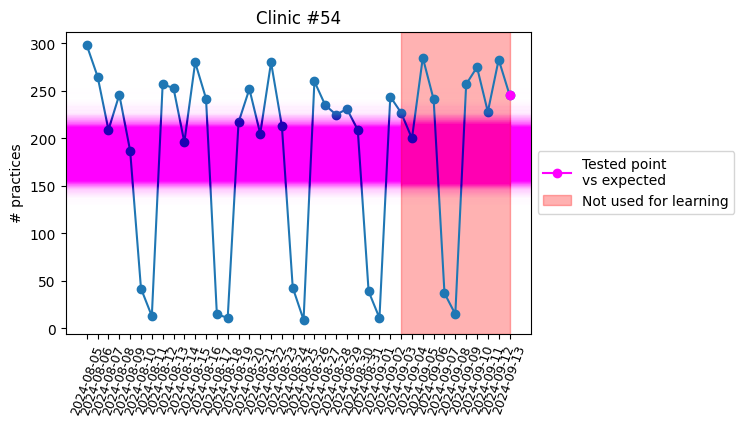

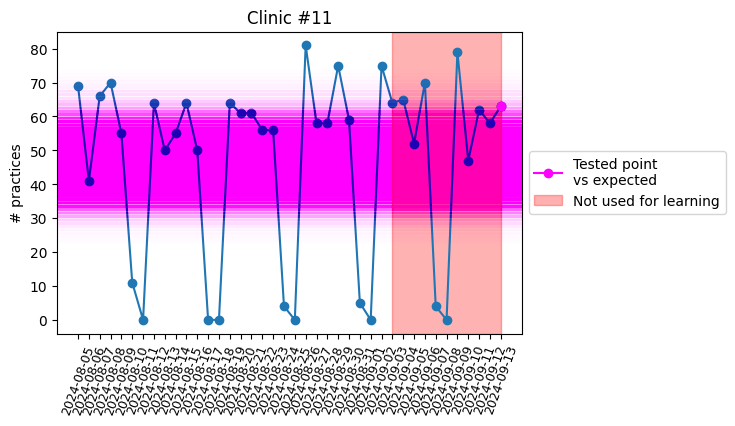

In [65]:
for name in list(probabilities)[:2]: 
    plt.plot(np.array(data0['Date'][:]), np.array(data0[name][:]),marker='o')
    plt.plot(np.array(data0['Date'])[-1], np.array(data0[name])[-1],marker='o',color='magenta', label='Tested point\nvs expected')
    #plt.scatter(np.array(data['Fecha'])[-day_of_study-1], np.array(data[name])[-day_of_study-1],marker='o',color='magenta', label='Tested point')
    plt.axvspan(np.array(data0['Date'])[start_not_learning_block],np.array(data0['Date'])[end_not_learning_block], alpha=0.3, color='red', label='Not used for learning')
    for i in range(len(probabilities.iloc[4][name])):
    #for i in range(10):
        tmp = stats.poisson.rvs(probabilities.iloc[4][name][i], size=3)
        for j in range(len(tmp)):
            plt.axhline(tmp[j], alpha=0.003, linestyle='solid', linewidth=4,  color='magenta')
        #plt.axhline(probabilities.iloc[4][name][i], alpha=0.003, linestyle='solid', color='red')
    plt.xticks(rotation=70, fontsize=9)
    plt.ylabel('# practices')
    plt.title(name)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

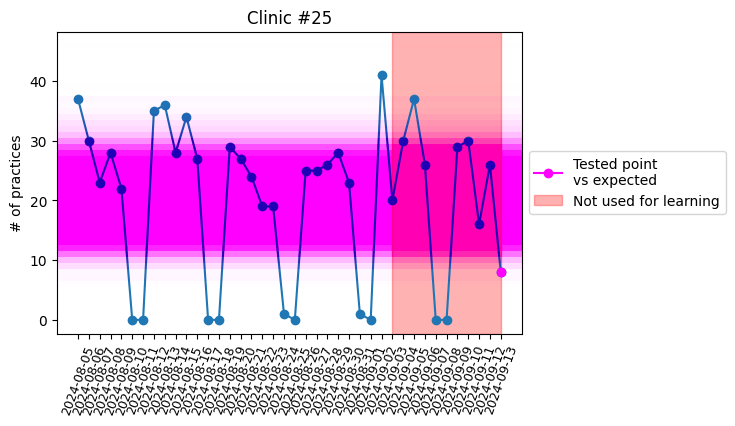

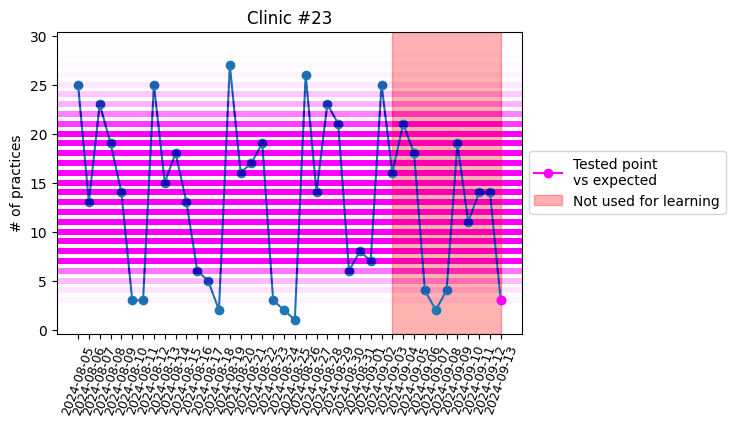

In [66]:
for name in list(probabilities)[-2:]: 
    plt.plot(np.array(data0['Date'][:]), np.array(data0[name][:]),marker='o')
    plt.plot(np.array(data0['Date'])[-1], np.array(data0[name])[-1],marker='o',color='magenta', label='Tested point\nvs expected')
    #plt.scatter(np.array(data['Fecha'])[-day_of_study-1], np.array(data[name])[-day_of_study-1],marker='o',color='magenta', label='Tested point')
    plt.axvspan(np.array(data0['Date'])[start_not_learning_block],np.array(data0['Date'])[end_not_learning_block], alpha=0.3, color='red', label='Not used for learning')
    for i in range(len(probabilities.iloc[4][name])):
    #for i in range(10):
        tmp = stats.poisson.rvs(probabilities.iloc[4][name][i], size=3)
        for j in range(len(tmp)):
            plt.axhline(tmp[j], alpha=0.003, linestyle='solid', linewidth=4,  color='magenta')
        #plt.axhline(probabilities.iloc[4][name][i], alpha=0.003, linestyle='solid', color='red')
    plt.xticks(rotation=70, fontsize=9)
    plt.ylabel('# of practices')
    plt.title(name)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()